# Climatology of weather-driven extremes in Europe's resources for renewable energy
### Ho and Fiedler (2024)
### Create five figures in the manuscript
<br>(2023-12-15) Combine all jupyter notebooks into one file
- Fig 1: bar plots if generation anomalies for PV, wind and total power
- Fig 2: scatter plots of anomalies
- Fig 3: Seasonal anomalies
- Fig 4: Atlas spatial distribution of power production anomalies by weather pattern
- Fig 5: Duration difference

In [40]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import seaborn as sns
import string
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pylab import savefig
plt.switch_backend('agg')  # save image in plt

from pandas.api.types import CategoricalDtype

from utils_LH import Dir, new_lat, new_lon, df_GWL, list_lgcGWL, anomalies_perGWL, GWL_groups, GWL_table, df_GWL_season
from utils_LH import rotated_projection_cosmo, cosmo_map_extent, newcmap_OrGy
from utils_LH import colour_list_GWL_groups, color_PV_wind_total

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]  # increase size of inline figure

In [2]:
# select only period of interest <========== and SEASON !!!
period = [1995,2017]
name_PERIOD = '{}_{}'.format(period[0], period[1])
print(name_PERIOD)

df_daily_all = df_GWL_season.loc[(df_GWL_season['Year']>=period[0]) & (df_GWL_season['Year']<=period[1])].copy()  # deep copy to create a real new copy not depend on the old df
df_hourly_all =  df_daily_all.set_index('Date').to_period().resample('H').ffill()

df_daily_all

1995_2017


,Year,Month,Day,id_EGWL,EGWL,id_lgcGWL,lgcGWL,Date,Season
0,1995,1,1,20,Np,13,Nz,1995-01-01,winter
1,1995,1,2,20,Np,13,Nz,1995-01-02,winter
2,1995,1,3,20,Np,13,Nz,1995-01-03,winter
3,1995,1,4,7,BMp,10,BM,1995-01-04,winter
4,1995,1,5,7,BMp,10,BM,1995-01-05,winter
...,...,...,...,...,...,...,...,...,...
8396,2017,12,27,49,TrWr,29,TrW,2017-12-27,winter
8397,2017,12,28,49,TrWr,29,TrW,2017-12-28,winter
8398,2017,12,29,10,Wz,2,Wz,2017-12-29,winter
8399,2017,12,30,10,Wz,2,Wz,2017-12-30,winter


In [31]:
### Time series with wind onshore and offshore threshold 0.5 for reviewed paper
### 2023-09-12
d=xr.open_dataset("/home/linhho/Documents/Code_PhD/CONST/COSMO_REA6_CONST_withOUTsponge.nc")
mask_land = d['FR_LAND'].data[::8, ::8] <= .5  ## masked OUT???
mask_sea  = d['FR_LAND'].data[::8, ::8] > .5

for name_scen in ['scale2019', 'scen2050']:
    label = 'on_offshore_wind_' + name_scen
    ts_all = pd.DataFrame(columns = ['time','PV', 'Wp_on', 'Wp_off'])

    for year in range(1995,2018):
        print(year, end =', ')
        if name_scen=='scen2050':        fname = Dir['out_dir'] + str(year) + '_PV_wind_generation_v2.nc'
        elif name_scen=='scale2019': fname = Dir['out_dir'] + '/scale2019/' + str(year) + '_PV_wind_generation_scale2019.nc'
        ds = xr.open_dataset(fname)
        tmp_wp_on = np.ma.array(ds['Wp2050'].data, mask=np.tile(mask_land, (len(ds.time),1,1)))
        tmp_wp_off = np.ma.array(ds['Wp2050'].data, mask=np.tile(mask_sea, (len(ds.time),1,1)))

        tmp_ts = pd.DataFrame({'time': pd.date_range(dt.datetime(year,1,1,0,0,0), dt.datetime(year+1,1,1,0,0,0), freq='H', closed="left"),
                                'PV': np.nansum(ds['PV2050'].data, axis=(1,2))/1000,
                                'Wp_on': np.nansum(tmp_wp_on, axis=(1,2))/1000,
                                'Wp_off': np.nansum(tmp_wp_off, axis=(1,2))/1000,
                                },
                                 columns = ['time','PV', 'Wp_on', 'Wp_off'])
        ts_all = pd.concat([ts_all, tmp_ts])

    print(fname, '\n Make sure there is no NaN in the time series ', np.sum(np.isnan(ts_all['PV'])), np.sum(np.isnan(ts_all['Wp_on'])), np.sum(np.isnan(ts_all['Wp_off'])))
    print('Mean hourly production {} for wind onshore {:.2f} and offshore {:.2f} GW'.format(name_scen, ts_all['Wp_on'].mean(), ts_all['Wp_off'].mean()))

    fname = '/net/respos/linhho/energy_model/mask/Timeseries_Europe_hourly_{}_{}_GW.csv'.format(name_PERIOD, label)
#     ts_all.to_csv(fname, sep='\t', index=False)

1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, /net/respos/linhho/energy_model//scale2019/2017_PV_wind_generation_scale2019.nc 
 Make sure there is no NaN in the time series  0 0 0
Mean hourly production on_offshore_wind_scale2019 onshore 25.67 and offshore 31.76 GW


## Figure 1: Anomalies of PV, wind and total generation for Europe (GW/hour)

In [21]:
## Dataframe of all statictics necessary to create the barplot/scatter of anomalies by GWL for two installed capacities

## Select SEASON
season_sel = 'annual'

for name_scen in ['scale2019', 'scen2050']:
    fname = '/net/respos/linhho/energy_model/mask/Timeseries_Europe_hourly_{}_on_offshore_wind_{}_GW.csv'.format(name_PERIOD, name_scen) ## with on offshore
    ts_all_from_file = pd.read_csv(fname, sep='\t')
    ts_all_raw = ts_all_from_file.copy()
    ts_all_raw['time'] = pd.to_datetime(ts_all_raw['time'])
    ts_all_from_file

    # DAILY ========== !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ts_all_raw['Wp'] = ts_all_raw['Wp_on'] + ts_all_raw['Wp_off']
    ts_all_raw['total'] = ts_all_raw['PV'] + ts_all_raw['Wp_on'] + ts_all_raw['Wp_off']
    ts_all_raw['Season'] = df_hourly_all['Season'].tolist()
    ts_all_raw['GWL'] = df_hourly_all['lgcGWL'].tolist()
    ts_all_raw = ts_all_raw.set_index('time')
    # from 2022-06-02, remove these 5 dates with missing data, denote as _v5
    # replace 1996-05-04--05 all zeros with None GWL to ignore in calculation
    ts_all_raw.loc['1996-05-04 00:00:00':'1996-05-05 23:00:00', 'GWL'] = None
    ts_all_raw.loc['2017-12-06 00:00:00':'2017-12-06 23:00:00', 'GWL'] = None
    ts_all_raw.loc['2005-10-17 00:00:00':'2005-10-17 23:00:00', 'GWL'] = None
    # Small Wp=0.18
    ts_all_raw.loc['1995-01-12 00:00:00':'1995-01-12 23:00:00', 'GWL'] = None

    ## Select SEASON
    if season_sel == 'annual': ts_all = ts_all_raw.copy() ;
    else: ts_all = ts_all_raw[ts_all_raw['Season']==season_sel].copy()
        
    ## save to use later for scatter plot
    if name_scen=='scen2050': ts_all_2050 = ts_all.copy()

    #### hourly mean of energy type in season_sel (winter/summer/annual)
    mean_total = np.nanmean(ts_all['total'])
    mean_PV = np.nanmean(ts_all['PV'])
    mean_Wp_on = np.nanmean(ts_all['Wp_on'])
    mean_Wp_off = np.nanmean(ts_all['Wp_off'])
    mean_Wp = np.nanmean(ts_all['Wp'])
    print(name_scen, season_sel)
    print('Mean total {:.2f}, mean PV {:.2f}, wind onshore {:.2f}, wind offshore {:.2f} GW'.format(
        mean_total, mean_PV, mean_Wp_on, mean_Wp_off))
    print('Percentage of PV power produces in the energy mix is {:.2f}'.format(mean_PV/mean_total))

    ## Anomalies (percentage) compared to mean hourly production of GWL of season
    stat_anomalies = ts_all.groupby(['GWL']).mean()
    stat_anomalies['total'] = (stat_anomalies['total'] - mean_total)/mean_total*100
    stat_anomalies['PV'] = (stat_anomalies['PV'] - mean_PV)/mean_PV*100

    ### fraction_on and off means how much (absolute value) anomalies of wind power come from wind on and offshore
    ### calculate using normalised anomalies separately for wind on and offshore would give too large value, easily > 80% in most cases for wind offshore
    ### and thus completely change Fig 1
    stat_anomalies['fraction_on']  = stat_anomalies['Wp_on'] / stat_anomalies['Wp']
    stat_anomalies['fraction_off']  = stat_anomalies['Wp_off'] / stat_anomalies['Wp']
    stat_anomalies['Wp'] = (stat_anomalies['Wp'] - mean_Wp)/mean_Wp*100
    stat_anomalies['Wp_on'] = stat_anomalies['Wp'] * stat_anomalies['fraction_on']
    stat_anomalies['Wp_off'] = stat_anomalies['Wp'] * stat_anomalies['fraction_off']

    stat_anomalies['Season'] = season_sel

    # Count the number of days with GWL
    counts = ts_all.groupby(['GWL'])
    ts_all_count = counts.size()/24 # actually a pd Series, both are 24 hours a day so don't need to divide by 24

    stat_anomalies['count_total'] = len(ts_all)/24
    stat_anomalies['count_day'] = np.nan
    for GWL in list_lgcGWL:
        stat_anomalies.at[GWL, 'count_day'] = ts_all_count[GWL]

    to_barplot = stat_anomalies[stat_anomalies['Season']==season_sel].copy()

    for GWL in list_lgcGWL:
        to_barplot.at[GWL, 'frequency'] = to_barplot.at[GWL, 'count_day'] / to_barplot.at[GWL, 'count_total'] * 100

    to_barplot['Group'] = None
    for group in list(GWL_groups.keys()):
        for GWL in GWL_groups[group]:
            to_barplot.at[GWL, 'Group'] = group

    to_barplot.reset_index(drop=False, inplace=True)

    if name_scen=='scale2019':      to_barplot2019 = to_barplot.copy()
    elif name_scen=='scen2050': to_barplot2050 = to_barplot.copy()
to_barplot2050

scale2019 annual
Mean total 75.31, mean PV 17.88, wind onshore 25.67, wind offshore 31.76 GW
Percentage of PV power produces in the energy mix is 0.24
scen2050 annual
Mean total 280.94, mean PV 129.65, wind onshore 67.63, wind offshore 83.67 GW
Percentage of PV power produces in the energy mix is 0.46


,GWL,PV,Wp_on,Wp_off,Wp,total,fraction_on,fraction_off,Season,count_total,count_day,frequency,Group
0,BM,11.660215,-4.658031,-5.902175,-10.560206,-0.305852,0.441093,0.558907,annual,8401.0,778.0,9.260802,group3_lowwindhighPV
1,HB,9.366263,-9.930441,-12.794467,-22.724909,-7.915368,0.436985,0.563015,annual,8401.0,266.0,3.166290,group3_lowwindhighPV
2,HFa,5.693870,-5.153060,-6.720174,-11.873234,-3.766309,0.434006,0.565994,annual,8401.0,214.0,2.547316,group2_average
3,HFz,-3.389638,-3.668561,-4.568341,-8.236902,-5.999971,0.445381,0.554619,annual,8401.0,255.0,3.035353,group2_average
4,HM,6.021056,-8.493435,-10.627370,-19.120805,-7.518255,0.444199,0.555801,annual,8401.0,351.0,4.178074,group3_lowwindhighPV
5,HNFa,27.724137,-9.567366,-13.965305,-23.532671,0.121491,0.406557,0.593443,annual,8401.0,175.0,2.083085,group3_lowwindhighPV
6,HNFz,-9.518246,-5.852927,-8.276846,-14.129774,-12.001630,0.414227,0.585773,annual,8401.0,218.0,2.594929,group2_average
7,HNa,11.792062,-12.496271,-16.663740,-29.160011,-10.261313,0.428541,0.571459,annual,8401.0,260.0,3.094870,group4_darkdoldrum
8,HNz,13.420539,-10.801331,-12.961425,-23.762756,-6.603286,0.454549,0.545451,annual,8401.0,196.0,2.333056,group3_lowwindhighPV
9,NEa,6.160970,-11.282786,-12.855226,-24.138012,-10.155537,0.467428,0.532572,annual,8401.0,152.0,1.809308,group3_lowwindhighPV


In [36]:
to_barplot2050.groupby('Group')['frequency'].sum()

Group
group1_highwindlowPV    32.793715
group2_average          28.353767
group3_lowwindhighPV    31.674801
group4_darkdoldrum       7.118200
Name: frequency, dtype: float64

In [7]:
# # Make sure color in the right group
# from pandas.api.types import CategoricalDtype
order_total_anomalies = to_barplot2050.sort_values('total')['GWL']
to_barplot2019['GWL'] = pd.Categorical(to_barplot2019['GWL'], categories=order_total_anomalies)
color_PV_wind_total = ['orange', '#4575A3', '#2c2c85', 'purple']

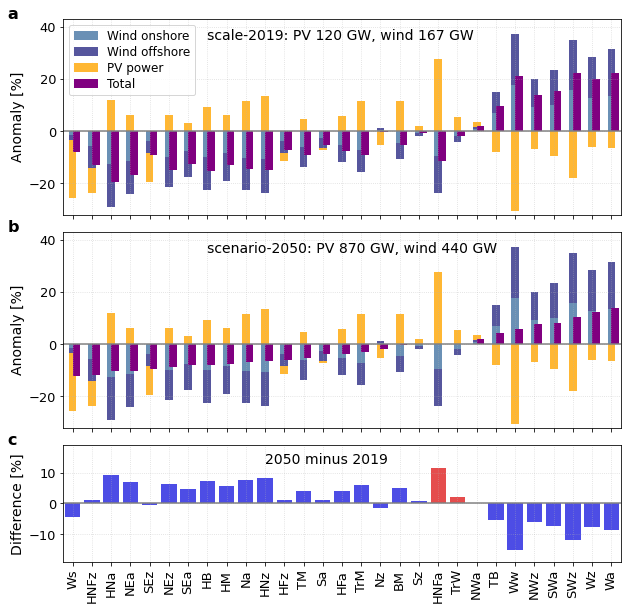

In [16]:
# bar plot of daily anomalies of PV and wind power stacked, in order of increasing total
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios':[1,1,.6]})
fig.subplots_adjust(hspace = 0.1) #, wspace=.15)

## Barplot of anomalies SCALE 2019 =========================

to_barplot2019[['GWL', 'Wp_on', 'Wp_off', 'PV']].set_index('GWL').reindex(order_total_anomalies).plot.bar(stacked=True, 
            color=[color_PV_wind_total[1], color_PV_wind_total[2], color_PV_wind_total[0]], label=['Wind power', 'PV power'], ax=axes[0], width=.4, alpha=.8, align='center')
to_barplot2019[['GWL', 'total']].set_index('GWL').reindex(order_total_anomalies).plot.bar(
            color=color_PV_wind_total[3], label=['Total'], ax=axes[0], stacked=False, align='edge', width=.4, alpha=1)
axes[0].grid(which='major', color='#B4B4B4', linestyle=':')
axes[0].set_ylabel('Anomaly [%]', fontsize=14)
axes[0].set_xlabel('')
plt.xticks(fontsize=14)
axes[0].tick_params(labelsize=13)
axes[0].legend(['Wind onshore', 'Wind offshore', 'PV power', 'Total'], loc='upper left', fontsize=12, labelspacing=.25)
axes[0].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[0].text(7, 35, 'scale-2019: PV 120 GW, wind 167 GW', fontsize=14)


## Barplot of anomalies 2050 =========================

to_barplot2050.sort_values('total')[['GWL', 'Wp_on', 'Wp_off', 'PV']].set_index('GWL').plot.bar(stacked=True, 
            color=[color_PV_wind_total[1], color_PV_wind_total[2], color_PV_wind_total[0]], label=['Wind power', 'PV power'], ax=axes[1], width=.4, alpha=.8, align='center')
to_barplot2050.sort_values('total')[['GWL', 'total']].set_index('GWL').plot.bar(
            color=color_PV_wind_total[3], label=['Total'], ax=axes[1], stacked=False, align='edge', width=.4, alpha=1)
axes[1].grid(which='major', color='#B4B4B4', linestyle=':')
axes[1].set_ylabel('Anomaly [%]', fontsize=14)
axes[1].set_xlabel('')
plt.xticks(fontsize=14)
axes[1].legend([],[], frameon=False)
axes[1].tick_params(labelsize=13)
axes[1].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[1].text(7, 35, 'scenario-2050: PV 870 GW, wind 440 GW', fontsize=14)

axes[0].set_ylim([-32,43])
axes[1].set_ylim([-32,43])

## Barplot of changes in anomalies from 2019 - 2050 =============================

df_change_sign = (to_barplot2050.set_index('GWL')['total'] - to_barplot2019.set_index('GWL')['total']).reset_index(drop=False)
df_change_sign['changed_sign'] = False
test_sign = to_barplot2050.set_index('GWL')['total'] * to_barplot2019.set_index('GWL')['total']
for GWL in list_lgcGWL:
    df_change_sign.loc[df_change_sign['GWL']==GWL, 'changed_sign'] = test_sign[GWL] < 0

changed_sign_palette = ['blue', 'red']
# df_change_sign.set_index('GWL').plot.bar(hue='changed_sign', palette=changed_sign_palette, ax=axes[2], width=.4, alpha=.8, align='center', order=order_total_anomalies)
sns.barplot(data=df_change_sign, x='GWL', y='total', ax=axes[2], hue='changed_sign', palette=changed_sign_palette, order=order_total_anomalies, alpha=.8, dodge=False)
axes[2].grid(which='major', color='#B4B4B4', linestyle=':')
axes[2].axhline(y=0, linestyle='-', color='grey', alpha=2)
axes[2].set_ylabel('Difference [%]', fontsize=14)
axes[2].set_xlabel('')
plt.xticks(rotation=90, fontsize=14)
axes[2].tick_params(labelsize=13)
plt.legend([],[], frameon=False)
axes[2].text(10, 13, r"2050 minus 2019", fontsize=14)
axes[2].set_ylim([-19,19])
# axes[2].set_yticklabels([-10,0,10])

## numbering subplots
axs = axes.flat
for n, ax in enumerate(axs):
    ax.text(-.1, 1, string.ascii_lowercase[n], transform=ax.transAxes, size=16, weight='bold')
    ax.grid(which='major', color='#B4B4B4', linestyle=':', alpha=.5)

# fig.savefig('Paper1/Paper1_v8_Fig1_Barplot_percentage_PV_wind_anomalies_hourly_withdifference_offshore.pdf', dpi=300, transparent=True, bbox_inches = "tight")

In [109]:
print('For scale-2019 total production min {:.2f}% and max {:.2f}%'.format(min(to_barplot2019['total']), max(to_barplot2019['total'])))
print('For scenario-2050 total production min {:.2f}% and max {:.2f}%'.format(min(to_barplot2050['total']), max(to_barplot2050['total'])))
print('For newratio5 total production min {:.2f}% and max {:.2f}%'.format(min(to_barplot['total']), max(to_barplot['total'])))

For scale-2019 total production min -19.46% and max 22.35%
For scenario-2050 total production min -12.10% and max 13.88%
For newratio5 total production min -16.50% and max 11.99%


# Figure 2: scatter plot of anomalies of PV power against that of wind power

In [62]:
## Select only SEASON
# Calculate frequency of GWL
counts = df_daily_all.copy().groupby(['lgcGWL'])
df_daily_frequency = counts.size()/len(df_daily_all)*100  # actually a pd Series

# Mean PV and wind and total production for each GWL
stats_overall = pd.DataFrame({'GWL': list_lgcGWL,
                              'frequency': np.nan,
                           'PV': np.nan,
                           'Wp': np.nan,
                           'total': np.nan,
                           },
                         columns = ['GWL', 'Frequency [%]', 'PV', 'Wp', 'Total [GW]'])
stats_overall =  stats_overall.set_index('GWL')

# Same as ts_all.groupby(['GWL']).mean()
for GWL in list_lgcGWL:
    stats_overall.at[GWL,'Frequency [%]'] = df_daily_frequency.loc[GWL]
    stats_overall.at[GWL,'PV'] = np.mean(ts_all_2050['PV'].loc[ts_all_2050['GWL']==GWL])
    stats_overall.at[GWL,'Wp'] = np.mean(ts_all_2050['Wp'].loc[ts_all_2050['GWL']==GWL])
    stats_overall.at[GWL,'Total [GW]'] = np.mean(ts_all_2050['total'].loc[ts_all_2050['GWL']==GWL])
stats_overall

,Frequency [%],PV,Wp,Total [GW]
GWL,,,,
Nz,1.70218,122.382,151.936,274.318
BM,9.2608,144.768,135.316,280.084
NWz,6.24926,120.82,181.665,302.485
SWa,4.66611,117.139,186.624,303.764
SWz,5.15415,106.425,203.858,310.283
Wz,9.32032,121.618,193.89,315.508
NWa,3.05916,132,153.918,285.918
HNa,3.09487,144.939,107.176,252.115
TrM,5.29699,144.726,127.515,272.241


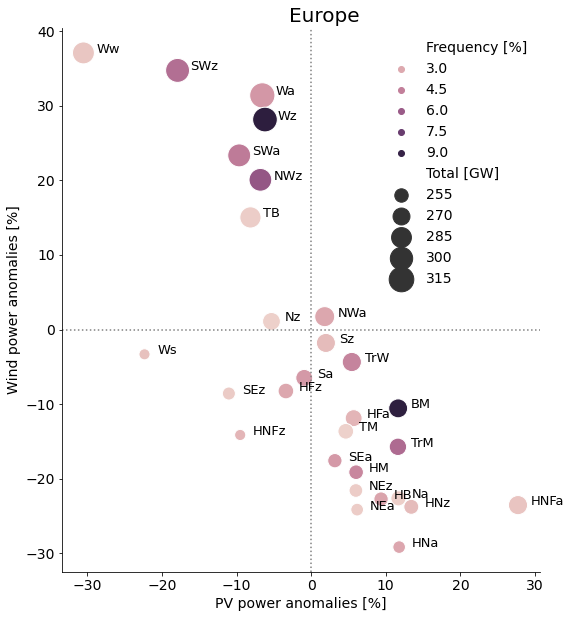

In [63]:
## Scatter plot WITHOUT normalised - version 4 (2022-05-05)
## Just (value - mean)/mean*100, limit axis is NOT 100 anymore
## Solve the inconsistency of Ws wind negative anomaly now

fig, ax = plt.subplots(figsize=(10,10))
minsize = min(stats_overall['Total [GW]'])/2
maxsize = max(stats_overall['Total [GW]'])*2
scatter = sns.scatterplot(data=to_barplot2050.set_index('GWL'), x='PV', y='Wp', hue=stats_overall['Frequency [%]'],  # palette=plt.get_cmap('magma_r'), 
                size=stats_overall['Total [GW]'], sizes=(minsize, maxsize)) #, style='Type')
#                 markers={'High PV & high wind':'s', 'High PV & low wind':'o', 'Low PV & high wind':'^', 'Low PV & low wind':'x'})
for i, point in to_barplot2050.set_index('GWL').iterrows():
    ax.annotate(i, (point['PV'], point['Wp']), textcoords='offset points', xytext=(13,0),
                family='sans-serif', fontsize=13, color='black')
ax.set_ylabel("Wind power anomalies [%]", fontsize=14)
ax.set_xlabel("PV power anomalies [%]", fontsize=14)
ax.set_title("Europe", position=(0.55, 0.95), fontsize=20)
ax.tick_params(labelsize=14)

ax.set_aspect('equal', adjustable='box')  # keep the same scale on x- and y-axis
ax.axhline(y=0, color='grey', linestyle=':')
ax.axvline(x=0, color='grey', linestyle=':')
legend = ax.legend(loc='upper right', fontsize=14)
legend.get_frame().set_linewidth(0.0)
# plt.legend(*scatter.legend_elements("sizes", num=4))

right_side = ax.spines["right"]
right_side.set_visible(False)
upper_side = ax.spines["top"]
upper_side.set_visible(False)

figname = 'Atlas_scatterplot_anomalies_GWL_' + name_PERIOD + '.pdf'
# fig.savefig('Paper1_{}_v4_Fig4_scatterplot_anomalies_GWL_hourly_percentage_NO_normalised.pdf'.format(name_PERIOD), dpi=300)

# Figure 3: Seasonal differences

In [25]:
stat_anomalies_from_csv = pd.read_csv('Paper1_stats_anomalies_percentage_hourly_byGWL_season_{}_{}.csv'.format(name_PERIOD, name_scen), sep='\t')
stat_anomalies_from_csv[stat_anomalies_from_csv['Season']=='winter'].sort_values('total')

,GWL,PV,Wp,total,Season,count_total,count_day
36,HNa,-14.919981,-26.168129,-22.481751,winter,4192.0,94.0
45,SEz,-22.603170,-17.290816,-19.031845,winter,4192.0,71.0
39,NEz,-1.648254,-22.071262,-15.377989,winter,4192.0,56.0
35,HNFz,-3.618163,-17.980351,-13.273402,winter,4192.0,103.0
30,HB,14.595669,-25.987954,-12.687402,winter,4192.0,135.0
33,HM,10.366817,-23.358431,-12.305588,winter,4192.0,197.0
44,SEa,7.212631,-20.721102,-11.566324,winter,4192.0,139.0
51,TM,6.738459,-20.247398,-11.403269,winter,4192.0,35.0
37,HNz,9.721390,-21.587213,-11.326382,winter,4192.0,68.0
42,Na,23.707677,-27.426839,-10.668422,winter,4192.0,85.0


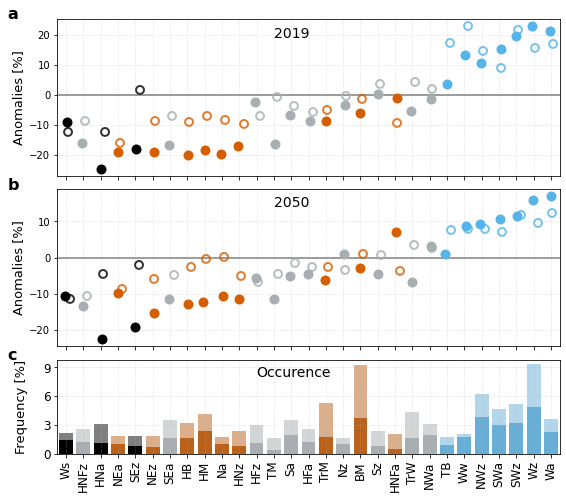

In [29]:
### SEASONALITY

## PLOT
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,8), sharex=True, gridspec_kw={'height_ratios':[1,1,.6]})
fig.subplots_adjust(hspace = 0.1) #, wspace=.15)
                                                                                             
### Total 2019 ===

stat_anomalies_from_csv2019 = pd.read_csv('Paper1_stats_anomalies_percentage_hourly_byGWL_season_1995_2017_scale2019.csv', sep='\t')
# order_total_anomalies = stat_anomalies_from_csv2019[stat_anomalies_from_csv2019['Season']=='annual'].sort_values('total')['GWL']
stat_anomalies_from_csv2050 = pd.read_csv('Paper1_stats_anomalies_percentage_hourly_byGWL_season_{}_scen2050.csv'.format(name_PERIOD), sep='\t')
order_total_anomalies = stat_anomalies_from_csv2050[stat_anomalies_from_csv2050['Season']=='annual'].sort_values('total')['GWL']

plot_season = stat_anomalies_from_csv2019.copy()[stat_anomalies_from_csv2019['Season'].isin(['winter', 'summer'])]
plot_season['Group'] = None
for group in list(GWL_groups.keys()):
    for GWL in GWL_groups[group]:
        plot_season.loc[plot_season['GWL']==GWL, 'Group'] = group
plot_season['Group'] = pd.Categorical(plot_season['Group'], categories=list(GWL_groups.keys()))

sns.stripplot(data=plot_season[plot_season['Season']=='winter'], x="GWL", y="total", hue="Group", s=10, palette=colour_list_GWL_groups, 
              order= order_total_anomalies, ax=axes[0])
sns.stripplot(data=plot_season[plot_season['Season']=='summer'], x="GWL", y="total", hue="Group", s=15, marker="$\circ$", 
              palette=colour_list_GWL_groups, order=order_total_anomalies, alpha=.8, ax=axes[0])

axes[0].grid(True, alpha=.3)
axes[0].axhline(y=0, linestyle='-', color='grey')
axes[0].set_ylabel('Anomalies [%]', fontsize=13)
axes[0].set_xlabel(None)
# plt.xticks(rotation=90, fontsize=12)
axes[0].legend([],[], frameon=False)
axes[0].text(12, 19, '2019', fontsize=14)

### 2050 ===

plot_season = stat_anomalies_from_csv2050.copy() # [stat_anomalies_from_csv['Season'].isin(['winter', 'summer'])]
plot_season['Group'] = None
for group in list(GWL_groups.keys()):
    for GWL in GWL_groups[group]:
        plot_season.loc[plot_season['GWL']==GWL, 'Group'] = group
plot_season['Group'] = pd.Categorical(plot_season['Group'], categories=list(GWL_groups.keys()))

sns.stripplot(data=plot_season[plot_season['Season']=='winter'], x="GWL", y="total", hue="Group", s=10, palette=colour_list_GWL_groups, 
              order= order_total_anomalies, ax=axes[1])
sns.stripplot(data=plot_season[plot_season['Season']=='summer'], x="GWL", y="total", hue="Group", s=15, marker="$\circ$", 
              palette=colour_list_GWL_groups, order=order_total_anomalies, alpha=.8, ax=axes[1])

axes[1].grid(True, alpha=.3)
axes[1].axhline(y=0, linestyle='-', color='grey')
axes[1].set_ylabel('Anomalies [%]', fontsize=13)
axes[1].set_xlabel(None)
axes[1].legend([],[], frameon=False)
axes[1].text(12, 14, '2050', fontsize=14)

### Frequency =============================================

barplot_season = plot_season.copy()
barplot_season['frequency'] = barplot_season['count_day'] / 8401.0 *100

sns.barplot(x="GWL",y="frequency",data=barplot_season[barplot_season['Season']=='winter'].sort_values('total'), hue='Group', 
            palette=colour_list_GWL_groups, dodge=False, order=order_total_anomalies, alpha=1)
sns.barplot(x="GWL",y="frequency",data=barplot_season[barplot_season['Season']=='annual'].sort_values('total'), hue='Group', 
            palette=colour_list_GWL_groups, dodge=False, order=order_total_anomalies, alpha=.5)

axes[2].grid(which='major', color='#B4B4B4', linestyle=':')
# axes[2].set_xticks([])   # no x-tick label
plt.xticks(rotation=90, fontsize=12)
axes[2].set_xlabel('', fontsize=12)
axes[2].set_yticks([0,3,6,9])
axes[2].tick_params(labelsize=12)
axes[2].set_ylabel('Frequency [%]', fontsize=13, labelpad=15)
axes[2].legend([],[], frameon=False)
axes[2].text(11, 8, 'Occurence', fontsize=14)

## numbering subplots
axs = axes.flat
for n, ax in enumerate(axs):
    ax.text(-.1, 1, string.ascii_lowercase[n], transform=ax.transAxes, size=16, weight='bold')
    ax.grid(which='major', color='#B4B4B4', linestyle=':', alpha=.5)
    
# fig.savefig('Paper1/Paper1_v8_Fig3_Seasonality_anomalies_total_1995_2017_with2019.pdf'.format(name_PERIOD), dpi=300, transparent=True, bbox_inches = "tight")

# Figure 4: Maps of anomalies of PV, wind, and total power production associated with weather patterns

In [ ]:
### Loop through GWL, selelct only corresponding timestep in COSMO-rea6 48km 1995--2017
### and corresponding power production

for GWL_extreme in list_lgcGWL:
    # get dataframe of GWL for each year, then get the indices of GWL in that dataframe
    for year in range(period[0], period[1]+1):
        # i+1 because python index is -1 of the usual indexing in CDO
        if  len(dict_GWL_id_year[GWL_extreme][year])==0:
            print('No data of {} in year {}'.format(GWL_extreme, year)); continue
        list_indices_with_comma = ','.join(str(i+1) for i in dict_GWL_id_year[GWL_extreme][year])

        # extract from COSMO-REa6 data only the timestep with selected GWL_extreme
        ifile = '/data/etcc/cosmo-rea6/hourly/48km/{}_COSMO-REA6_hourly_48km.nc'.format(year)
        ofile = '/net/respos/linhho/cosmo-rea6_processed/selected_COSMO-REA6_hourly_48km_{}_{}.nc'.format(GWL_extreme, year)
        cdo.seltimestep(list_indices_with_comma, input = ifile, output = ofile)  #, options='-selvar,pmsl')

    # Combine all data from each year into one file
    # then delete temporary files???
    cdo.cat(input = dir_cosmorea6_processed + 'selected_COSMO-REA6_hourly_48km_{}_????.nc'.format(GWL_extreme), 
            output = dir_cosmorea6_processed + 'selected_COSMO-REA6_hourly_48km_{}_all.nc'.format(GWL_extreme))
    for f in glob.glob('/net/respos/linhho/cosmo-rea6_processed/selected_COSMO-REA6_hourly_48km_{}_????.nc'.format(GWL_extreme)):
        os.remove(f)
        
### Loop through GWL, selelct only corresponding timestep in REM output 1995--2017 (copy from Paper1_Fig5_meteorological_map.ipynb)

for GWL_name in list_lgcGWL:
    # get dataframe of GWL for each year, then get the indices of GWL in that dataframe
    for year in range(period[0], period[1]+1):
        # i+1 because python index is -1 of the usual indexing in CDO
        if  len(dict_GWL_id_year[GWL_name][year])==0:
            print('No data of {} in year {}'.format(GWL_name, year)); continue
        list_indices_with_comma = ','.join(str(i+1) for i in dict_GWL_id_year[GWL_name][year])

        # extract from COSMO-REa6 data only the timestep with selected GWL_name
        ifile = Dir['out_dir'] + '{}_PV_wind_generation_v2.nc'.format(year)
        ofile = '/net/respos/linhho/cosmo-rea6_processed/selected_PV_wind_generation_{}_{}.nc'.format(GWL_name, year)
        cdo.seltimestep(list_indices_with_comma, input = ifile, output = ofile)  #, options='-selvar,pmsl')

    # Combine all data from each year into one file
    # then delete temporary files???
    cdo.cat(input = dir_cosmorea6_processed + 'selected_PV_wind_generation_{}_????.nc'.format(GWL_name), 
            output = dir_cosmorea6_processed + 'selected_PV_wind_generation_{}_all.nc'.format(GWL_name))
    for f in glob.glob('/net/respos/linhho/cosmo-rea6_processed/selected_PV_wind_generation_{}_????.nc'.format(GWL_name)):
        os.remove(f)

In [36]:
# get mean values of MSL pressure and total radiation from pre-calculated CDO in cosmo-rea6/hourly
# mistake lon <-> lat from CFrank
file_pmsl = xr.open_dataset('/data/etcc/cosmo-rea6/hourly/PMSL.2D/mean_1995_2017_PMSL.nc').rename_dims({'rlat':'lon', 'rlon':'lat'})
file_SWDIR = xr.open_dataset('/data/etcc/cosmo-rea6/hourly/SWDIRS_RAD.2D/mean_1995_2017_SWDIRS_RAD.nc').rename_dims({'rlat':'lon', 'rlon':'lat'})
file_SWDIFD = xr.open_dataset('/data/etcc/cosmo-rea6/hourly/SWDIFDS_RAD.2D/mean_1995_2017_SWDIFDS_RAD.nc').rename_dims({'rlat':'lon', 'rlon':'lat'})

mean_pmsl = file_pmsl['msl'][0,:,:]
mean_radiation = file_SWDIR['ASWDIR_S'][0,:,:] + file_SWDIFD['ASWDIFD_S'][0,:,:]

# select every 8 grid boxes to compatible with the energy model output (824,848) --> (103,106)
mean_pmsl = mean_pmsl[::8,::8].load()/100
mean_radiation = mean_radiation[::8,::8].load()
print(mean_pmsl.shape, mean_radiation.shape)

(103, 106) (103, 106)


In [34]:
dir_cosmorea6_processed = '/net/respos/linhho/cosmo-rea6_processed/'

mean_file = '/net/respos/linhho/energy_model/scale2019/mean_hourly_1995_2017_PV_wind_generation_scale2019.nc'
mean_ds = xr.open_dataset(mean_file)
PV_mean_2019 = mean_ds['PV2019']
Wp_mean_2019 = mean_ds['Wp2019']
total_mean_2019 = PV_mean_2019 + Wp_mean_2019  # np.nansum(total, axis=0)/ds.sizes['time']

mean_file = '/net/respos/linhho/energy_model/mean_hourly_1995_2017_PV_wind_generation.nc'
mean_ds = xr.open_dataset(mean_file)
PV_mean = mean_ds['PV2050']
Wp_mean = mean_ds['Wp2050']
total_mean = PV_mean + Wp_mean  # np.nansum(total, axis=0)/ds.sizes['time']

<ipython-input-41-b1b003cb8291>:25: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.05, bottom=0.02, right=0.95, top=0.94, wspace=0.05)
/home/linhho/miniconda3/envs/py3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
<ipython-input-41-b1b003cb8291>:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


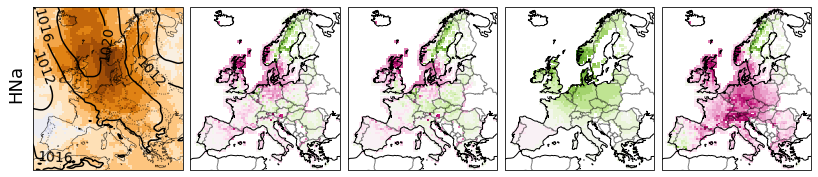

In [41]:
### composite maps for === SCALE 2019 and SCENARIO 2050 ===
## 5 panels: met, total 2019, total 2050, PV, wind power

dir_processed_2019 = '/net/respos/linhho/energy_model/scale2019/processed/'

import matplotlib.gridspec as gridspec

cosmo_map_extent = [-23, 11, -16, 21]  # increase latitudes to keep the same height of subplots
clevs = np.arange(960,1030,4)
pressure_color = 'black'
# col_bar_shrink = 1


for GWL_name in ['HNa', 'Ws', 'Wa', 'HNFa']: # list_lgcGWL:
    y_label = '{}'.format(GWL_name)
#     my_title = GWL_name + ' \n ' + GWL_table.definition.loc[GWL]
    
    
    fig = plt.figure(constrained_layout=True, figsize=(12,3))
    widths = [5,5,5,5,5]
    heights = [5]
    spec = gridspec.GridSpec(ncols=5, nrows=1, width_ratios=widths, height_ratios=heights, figure=fig)
    fig.subplots_adjust(left=0.05, bottom=0.02, right=0.95, top=0.94, wspace=0.05)
    
    # read data only timesteps of selected GWL
    ## 2019
    fname_PV_wp = '{}/selected_PV_wind_generation_scale2019_{}_all.nc'.format(dir_processed_2019, GWL_name)
    ds_PV_wp = xr.open_dataset(fname_PV_wp)
    total = ds_PV_wp['PV2050'].fillna(0) + ds_PV_wp['Wp2050']
    toplot1 = (np.nansum(total, axis=0)/len(ds_PV_wp['time']) - total_mean_2019)/total_mean_2019*100;                  toplot1 = toplot1.where(toplot1 != 0)

    ## 2050, PV and wind power anomalies are the same as for 2019
    fname_PV_wp = '/net/respos/linhho/energy_model/processed/annual/selected_PV_wind_generation_{}_all.nc'.format(GWL_name)
    ds_PV_wp = xr.open_dataset(fname_PV_wp)
    total = ds_PV_wp['PV2050'].fillna(0) + ds_PV_wp['Wp2050']

    toplot2 = (np.nansum(total, axis=0)/len(ds_PV_wp['time']) - total_mean)/total_mean*100;                  toplot2 = toplot2.where(toplot2 != 0)
    toplot3 = (np.nansum(ds_PV_wp['PV2050'],axis=0)/len(ds_PV_wp['time']) - PV_mean )/PV_mean*100;           toplot3 = toplot3.where(toplot3 != 0)
    toplot4 = (np.nansum(ds_PV_wp['Wp2050'],axis=0)/len(ds_PV_wp['time']) - Wp_mean)/Wp_mean*100;            toplot4 = toplot4.where(toplot4 != 0)

    fname_GWL = dir_cosmorea6_processed + 'annual/selected_COSMO-REA6_hourly_48km_{}_all.nc'.format(GWL_name)
    ds_GWL = xr.open_dataset(fname_GWL)

    pmsl_contour = np.sum(ds_GWL['pmsl'], axis=0)/len(ds_GWL['time'])/100
    rad_shading = np.sum(ds_GWL['total_radiation'], axis=0)/len(ds_GWL['time']) - mean_radiation

    #########################################
    #   Meteorological condition
    #########################################
    colorbar_range = [-60, 60] 
    my_cmap = plt.get_cmap('PuOr_r', 16)
    
    ax00 = fig.add_subplot(spec[0,0], projection=rotated_projection_cosmo)  
    mesh0 = ax00.pcolormesh(new_lon, new_lat, rad_shading,
                 transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
    ax00.coastlines(alpha=.7, linewidth=.6)
    ax00.add_feature(cartopy.feature.BORDERS, alpha = 0.5, linestyle=':')
    ax00.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map


    cs = ax00.contour(new_lon, new_lat, pmsl_contour, clevs, linewidths=1.5, colors=pressure_color,
                 transform=ccrs.PlateCarree())
    ax00.clabel(cs, inline=1, fmt='%.0f', fontsize=14)  #, colors='green')
    
    #########################################
    #   total PV + Wp(2050) annual
    #########################################
    # setting for total, PV, wind power
    col_bar_shrink = 1.2
    colorbar_range = [-80, 80]  # [-PV_range, PV_range]
    my_cmap = plt.get_cmap('PiYG',20)

    ## 2019
    ax01 = fig.add_subplot(spec[0,1], projection=rotated_projection_cosmo)
    mesh = ax01.pcolormesh(new_lon, new_lat, toplot1,
                 transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
    ax01.coastlines()
    ax01.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
    ax01.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map

    ## 2050
    ax02 = fig.add_subplot(spec[0,2], projection=rotated_projection_cosmo)
    mesh = ax02.pcolormesh(new_lon, new_lat, toplot2,
                 transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
    ax02.coastlines()
    ax02.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
    ax02.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map
#     ax02.set_title('Total')

    #########################################
    #   PV annual
    #########################################

    ax03 = fig.add_subplot(spec[0,3], projection=rotated_projection_cosmo)
    mesh = ax03.pcolormesh(new_lon, new_lat, toplot3,
                 transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
    ax03.coastlines()
    ax03.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
    ax03.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map
#     ax03.set_title('PV power')

    #########################################
    #   Wind power annual
    #########################################

    ax04 = fig.add_subplot(spec[0,4], projection=rotated_projection_cosmo)
    mesh = ax04.pcolormesh(new_lon, new_lat, toplot4,
                 transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
    ax04.coastlines()
    ax04.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
    ax04.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map
#     ax04.set_title('Wind power')
    
    fig.text(0.03, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=18)
    fig.tight_layout()
    
#     fig.text(0.1, 0.5, title, ha='center', va='center', rotation='vertical', fontsize=18)
#     fig.savefig('/net/respos/linhho/PLOT_29climatology_thesis/Composite_map_meteological_{}_{}_allyear_percentage80.pdf'.format(name_PERIOD, GWL_name), dpi=200, transparent=True)


<ipython-input-42-511486ffd377>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/net/respos/linhho/PLOT_29climatology_thesis/Composite_map_ONLY_COLOURBAR_power_percentage80.pdf', dpi=200, transparent=True, figsize=(3,1))


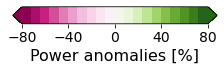

In [42]:
fig = plt.figure(constrained_layout=True, figsize=(3,3))
plt.gca().set_visible(False)
ax01 = plt.colorbar(mesh, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both',
                       ticks=[-80, -40, 0, 40, 80])
ax01.ax.tick_params(labelsize=14)
ax01.set_label('Power anomalies [%]', fontsize=16)
# plt.savefig('/net/respos/linhho/PLOT_29climatology_thesis/Composite_map_ONLY_COLOURBAR_power_percentage80.pdf', dpi=200, transparent=True, figsize=(3,1))

<ipython-input-43-4720a600f74e>:4: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  ax01 = plt.colorbar(mesh0, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both',


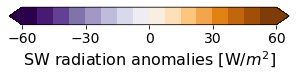

In [43]:
fig = plt.figure(constrained_layout=True, figsize=(4,3))
my_cmap = plt.get_cmap('PuOr_r', 16)
plt.gca().set_visible(False)
ax01 = plt.colorbar(mesh0, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both',
                       ticks=[-60, -30, 0, 30, 60], cmap=my_cmap)
ax01.ax.tick_params(labelsize=14)
ax01.set_label('SW radiation anomalies [W/$m^2$]', fontsize=16)
# plt.savefig('/net/respos/linhho/PLOT_29climatology_thesis/Composite_map_ONLY_COLOURBAR_pmslrad_abs60.pdf', dpi=200, transparent=True)

# Figure 5: Lowest and highest production with 1-, 5-, 10-day durations
### for Europe and four selected regions

In [259]:
## Scatter plots for 4 regions
# read energy data
fname = Dir['out_dir'] + '????_PV_wind_generation_v2.nc'
ds = xr.open_mfdataset(fname, parallel=True)

region = 'C'

if region=='Europe':  ## whole Europe
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 0,103,0,106
elif region=='A':  ## Scandinavia
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 82,102,57,77  # Scandinavia  ## new, ver2, to capture the tip of Scandinavia which is anti-correlated with Western Europe (2022-05-30)
elif region=='B':  # ## Germany and North Sea
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 50,70,40,60
elif region=='C':  # ## Iberia
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 25,45,15,35
elif region=='D':  # ## Southeastern Europe
    reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 20,40,60,80

PV_domain = ds['PV2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]
Wp_domain = ds['Wp2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]

ts_all_reg = pd.DataFrame({'time': pd.date_range(dt.datetime(period[0],1,1,0,0,0), dt.datetime(period[1]+1,1,1,0,0,0), freq='H', closed="left"),
                           'PV': np.nansum(PV_domain, axis=(1,2)),
                           'Wp': np.nansum(Wp_domain, axis=(1,2)),
                           'GWL': np.repeat(df_daily['lgcGWL'], 24).tolist()
                           },
                         columns = ['time','PV', 'Wp', 'GWL'])
ts_all_reg['total'] = ts_all_reg['PV'] + ts_all_reg['Wp']
ts_all_reg

,time,PV,Wp,GWL,total
0,1995-01-01 00:00:00,0.0,27941.600956,Nz,27941.600956
1,1995-01-01 01:00:00,0.0,26747.777948,Nz,26747.777948
2,1995-01-01 02:00:00,0.0,25598.597420,Nz,25598.597420
3,1995-01-01 03:00:00,0.0,25136.228166,Nz,25136.228166
4,1995-01-01 04:00:00,0.0,24197.010543,Nz,24197.010543
...,...,...,...,...,...
201619,2017-12-31 19:00:00,0.0,23371.176920,Wz,23371.176920
201620,2017-12-31 20:00:00,0.0,23457.380476,Wz,23457.380476
201621,2017-12-31 21:00:00,0.0,24344.196669,Wz,24344.196669
201622,2017-12-31 22:00:00,0.0,23618.363248,Wz,23618.363248


AttributeError: 'NoneType' object has no attribute 'ax'

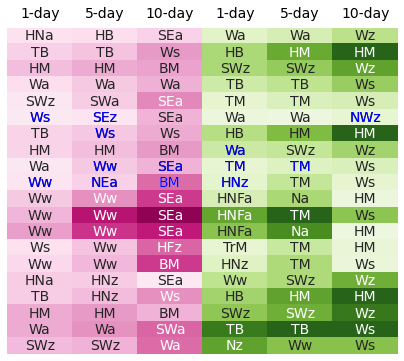

In [66]:
## Dataframe of lowest and highest power production
## NEW update Scandinavia Northern tip (2022-05-30)
# by **** Energy type ****

plt.figure(figsize=(7,6))

# Defining index
idx = ['Europe_total_2019', 'Scandi_total_2019', 'Germany_total_2019', 'Iberia_total_2019', 'Eastern_total_2019',
       'Europe_total', 'Scandi_total', 'Germany_total', 'Iberia_total', 'Eastern_total',
       'Europe_PV', 'Scandi_PV', 'Germany_PV', 'Iberia_PV', 'Eastern_PV', 
       'Europe_wind', 'Scandi_wind', 'Germany_wind', 'Iberia_wind', 'Eastern_wind'
       ]

# Defining columns
cols = ['Low_1', 'Low_5', 'Low_10',
       'High_1', 'High_5', 'High_10']

y_axis_labels = ['Europe', 'I', 'II', 'III', 'IV', 
          'Europe', 'I', 'II', 'III', 'IV', 
          'Europe', 'I', 'II', 'III', 'IV']
x_axis_labels = ['1-day', '5-day', '10-day', '1-day', '5-day', '10-day']

# Enter data and convert to dataframe with corresponding index and column
# Europe  # Iberia  # Germany & North Sea  # Scandinavia  # Eastern Europe
df = pd.DataFrame([ [-19, -21, -27, 22, 27, 39], [-28, -34, -49, 44, 68, 130], [-36, -43, -46, 44, 52, 72], [-21, -31, -42, 31, 37, 50], [-14, -29, -54, 20, 25, 27] ,  # total 2019
                    [-12, -16, -41, 14, 12, 18], [-26, -32, -43, 41, 60, 120], [-26, -36, -49, 32, 35, 47], [-14, -31, -41, 18, 24, 25], [-17, -28, -62, 21, 35, 20],    # total
                    [-31, -52, -73, 27, 45, 14],  [-40, -85, -99, 71, 100, 55], [-47, -75, -82, 56, 82, 12], [-19, -34, -64, 19, 33, 17], [-24, -39, -73, 23, 43, 15], # PV
                    [-29, -30, -13, 37, 43, 66], [-29, -37, -52, 47, 72, 137], [-43, -49, -41, 54, 66, 91], [-43, -51, -64, 90, 104, 119], [-38, -41, -62, 72, 57, 57]    # wind
                   ],
                  columns = cols, index = idx
                 )

df_GWL = pd.DataFrame([ ['HNa', 'HB', 'SEa', 'Wa', 'Wa', 'Wz'], ['TB', 'TB', 'Ws', 'HB', 'HM', 'HM'], ['HM', 'HM', 'BM', 'SWz', 'SWz', 'Wz'], ['Wa', 'Wa', 'Wa', 'TB', 'TB', 'Ws'], ['SWz', 'SWa', 'SEa', 'TM', 'TM', 'Ws'],  # total 2019
                        ['Ws', 'SEz', 'SEa', 'Wa', 'Wa', 'NWz'], ['TB', 'Ws', 'Ws', 'HB', 'HM', 'HM'], ['HM', 'HM', 'BM', 'Wa', 'SWz', 'Wz'], ['Wa', 'Ww', 'SEa', 'TM', 'TM', 'Ws'], ['Ww', 'NEa', 'BM', 'HNz', 'TM', 'Ws'],  # total
                        ['Ww', 'Ww', 'SEa', 'HNFa', 'Na', 'HM'], ['Ww', 'Ww', 'SEa', 'HNFa', 'TM', 'Ws'], ['Ww', 'Ww', 'SEa', 'HNFa', 'Na', 'HM'], ['Ws', 'Ww', 'HFz', 'TrM', 'TM', 'HM'], ['Ww', 'Ww', 'BM', 'HNz', 'TM', 'Ws'], # PV 
                        ['HNa', 'HNz', 'SEa', 'Ww', 'SWz', 'Wz'], ['TB', 'HNz', 'Ws', 'HB', 'HM', 'HM'], ['HM', 'HM', 'BM', 'SWz', 'SWz', 'Wz'], ['Wa', 'Wa', 'SWa', 'TB', 'TB', 'Ws'], ['SWz', 'SWz', 'Wa', 'Nz', 'Ww', 'Ws'] # wind                       
                      ],
                     columns = cols, index = idx 
                     )
df_GWL_change2050 = pd.DataFrame([ ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''],  # total 2019
                                  ['Ws', 'SEz', '', '', '', 'NWz'], ['', 'Ws', '', '', '', ''], ['', '', '', 'Wa', '', ''], ['', 'Ww', 'SEa', 'TM', 'TM', ''], ['Ww', 'NEa', 'BM', 'HNz', '', ''],  # total 2050
                                  ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''], # PV 2050
                                  ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', ''], ['', '', '', '', '', '']  # wind 2050
                      ],
                     columns = cols, index = idx 
                     )

sns.heatmap(df, cmap=plt.get_cmap('PiYG'), linewidths = 0.30, annot = False, vmin=-100, vmax=100, cbar=False)
myplot = sns.heatmap(df, cmap=plt.get_cmap('PiYG'), annot=df_GWL, vmin=-100, vmax=100, annot_kws={'va':'center', "fontsize":14}, fmt="", cbar=False, yticklabels=False)
myplot2 = sns.heatmap(df, cmap=plt.get_cmap('PiYG'), annot=df_GWL_change2050, vmin=-100, vmax=100, annot_kws={'va':'center', "fontsize":14, "color":"blue"}, fmt="", cbar=False, yticklabels=False)


plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, left=True)  # no tick, no x label
myplot.set_xticklabels(x_axis_labels, size = 14)
# myplot.set_yticklabels(y_axis_labels, size = 14)

# use matplotlib.colorbar.Colorbar object
cbar = myplot.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
# plt.savefig('Paper1_v7_Table1_lowest_highest_production_total2019_total2050_PVwind2050.pdf'.format(name_PERIOD), dpi=300)

In [64]:
len(y_axis_labels)

15